===================== Import Packages ====================

In [23]:
import sys, os, pdb, glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table, join, MaskedColumn
from astroquery.vizier import Vizier
import warnings
from astropy.logger import AstropyWarning
warnings.filterwarnings('ignore', category=AstropyWarning)

===================== Define Functions ===================

In [24]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEN
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t

In [25]:
def spt_coding(spt):

    """
    PURPOSE:    Translate spectral type (e.g., M7) into numerical value
                that can be used for plotting a histogram

                Scale is 0 at M0, -1 at K7, -8 at K0, -18 at G0
                (K8 is counted as M0)

    INPUT:      spt = numpy array of spectral types (str, masked)
                (masked values are unknonw spectral types)

    OUTPUT:     spt_num = numpy array of numerical spectral types (obj, masked)
                (returns -99. if unknown spectral type)
    
    """

    spt_num = np.empty(len(spt), dtype=object)
    for i, val in enumerate(spt):

        if val == '':
            spt_num[i] = -99.

        else:

            if val == 'M1+M2':
                val = 'M1.5'
            if val[0] == 'M':
                spt_num[i] = float(val[1:])
            if val[0] == 'K':
                spt_num[i] = float(val[1:]) - 8.
            if val[0] == 'G':
                spt_num[i] = float(val[1:]) - 18.
            if val[0] == 'F':
                spt_num[i] = float(val[1:]) - 28.
            if val[0] == 'A':
                spt_num[i] = float(val[1:]) - 38.
 
    return spt_num

========================== Code ==========================

In [26]:
### LOAD IN LUPUS DATA
T = get_data("J/ApJ/828/46", join_type='outer')

In [27]:
### FLAG UNDETECTED SOURCES
T.add_column(MaskedColumn(name='Detected', data=T['F890']/T['e_F890'] > 3.0))

In [28]:
### GET SPECTRAL TYPE CODING FOR PLOTTING (ALL, NON-DETECTIONS, UNOBSERVED)
Spt_All = spt_coding(T['SpT'])
Spt_Ndt = spt_coding(T['SpT'][np.where(~T['Detected'])])
Spt_Obs = spt_coding(T['SpT'][~T['F890'].mask])

(0.0, 25.0)

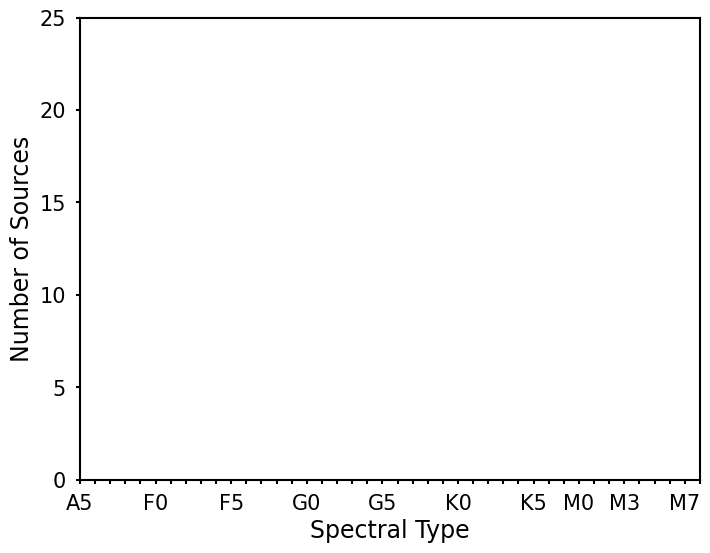

In [29]:
### SETUP PLOT
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
mpl.rc('xtick.major', size=3, pad=7, width=1.5)
mpl.rc('ytick.major', size=3, pad=7, width=1.5)
mpl.rc('axes', linewidth=1.5)
mpl.rc('lines', markersize=5)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_xlabel('Spectral Type', fontsize=17)
ax.set_ylabel("Number of Sources", fontsize=17)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
nxticks    = np.arange(-33, 9, 1)
ticklabels = np.array(['A5', '', '', '', '', 'F0', '', '', '', '', 'F5', '', '', '', '', 'G0', '', '', '', '', 'G5', '', '', '', '',
                        'K0', '', '', '', '', 'K5', '', '', 'M0', '', '', 'M3', '', '', '', 'M7', ''])
ax.set_xticks(nxticks)
ax.set_xticklabels(ticklabels)
ax.set_xlim(np.min(nxticks), np.max(nxticks))
ax.set_ylim(0, 25)

In [30]:
### PLOT DIFFERENT SAMPLES
bins_spt = np.arange(-33, 9, 2)
ax.hist(Spt_All, bins_spt, align='left', lw=2, histtype='step', color='black', label='All Sources')
ax.hist(Spt_Obs, bins_spt, align='left', facecolor='lightblue', hatch='//', lw=2, histtype='stepfilled', label='Observed', edgecolor='black')
ax.hist(Spt_Ndt, bins_spt, align='left', color='red', lw=2, histtype='step', label='Undetected')
ax.legend(loc='upper left', prop={'size': 16}, edgecolor='black')

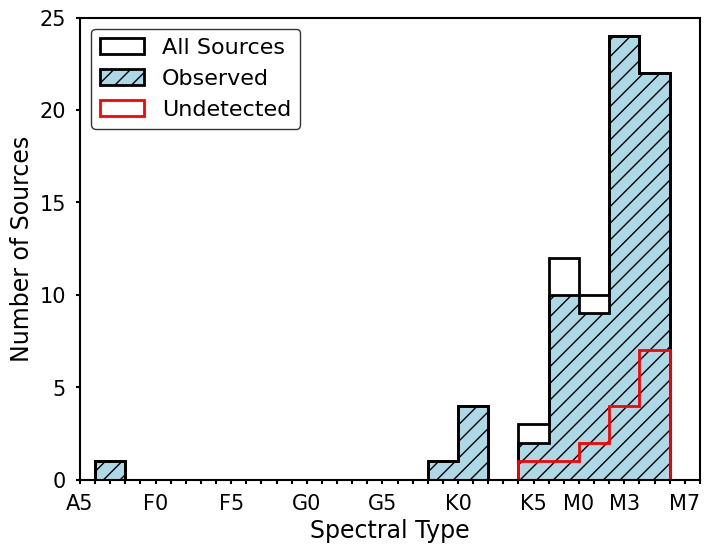

In [31]:
### SAVE FIGURE
fig.savefig('../output/figure_01.png', bbox_inches='tight', dpi=100)
fig

In [32]:
plt.close('all')